# An Illustrative Introduction to Dynamic Time Warping

Dynamic Time Warping (DTW) is a way to compare two -usually temporal- sequences that do not sync up perfectly. It is a method to calculate the optimal matching between two sequences. DTW is useful in many domains such as speech recognition, data mining, financial markets, etc. It's commonly used in data mining to measure the distance between two time-series.

In this post, we will go over the mathematics behind DTW. Then, two illustrative examples are provided to better understand the concept. If you are not interested in the math behind it, please jump to examples.

## Formulation
Let's assume we have two sequences like the following:
$$X = x_1, \; x_2, \; ..., \; x_i, \; ... , \; x_n$$
$$Y = y_1, \; y_2, \; ..., \; y_j, \; ... , \; y_m$$
The sequences $X$ and $Y$ can be arranged to form an $n$-by-$m$ grid, where each point ($i$, $j$) is the alignment between $x_i$ and $y_j$. 

A warping path $W$ maps the elements of $X$ and $Y$ to minimize the _distance_ between them. $W$ is a sequence of grid points $(i, j)$. We will see an example of the warping path later. 

### Warping Path and DTW distance

The Optimal path to ($i_k$, $j_k$) can be computed by:

$$D_{min}(i_k, j_k) = \underset{i_{k-1},\space j_{k-1}}{\text{min}} D_{min}(i_{k-1}, j_{k-1}) + d(i_k, j_k | i_{k-1}, j_{k-1})$$

where $d$ is the Euclidean distance $d(i, j) = || f_1(i) - f_2(j)||$

Overall path cost: $D = \sum_{k} d(i_k, j_k)$

## Restrictions on the Warping function
The warping path is found using a dynamic programming approach to align two sequences. Going through all possible paths is "combinatorically explosive"$^{[1]}$. Therefore, for efficiency purposes, it's important to limit the number of possible warping paths, and hence the following constraints are outlined:
- **Boundary Condition**: This constraint ensures that the warping path begins with the start points of both signals and terminates with their endpoints.
$$i_1 = 1, i_k = n \;\;\; \text{and} \;\;\; j_1=1, j_k=m$$


- **Monotonicity condition**: This constraint preserves the time-order of points (not going back in time).
$$i_{t-1} \le i_t \;\;\; \text{and} \;\;\; j_{t-1} \le j_t$$
                            
                            
- **Continuity (step size) condition**: This constraint limits the path transitions to adjacent points in time (not jumping in time).
$$i_t - i_{t-1} \le 1 \;\;\; \text{and} \;\;\; j_t - j_{t-1} \le 1$$

In addition to the above three constraints, there are other less frequent conditions for an allowable warping path:
- **Warping window condition**: Allowable points can be restricted to fall within a given warping window of width $\omega$ (a positive integer).
$$|i_t - j_t| \le \omega$$

- **Slope condition**: The warping path can be constrained by restricting the slope, and consequently avoiding extreme movements in one direction. 


An acceptable warping path has combinations of **chess king** moves that are:
- Horizontal moves: $(i, j) \rightarrow (i, j+1)$
- Vertical moves: $(i, j) \rightarrow (i+1, j)$
- Diagonal moves: $(i, j) \rightarrow (i+1, j+1)$

## Implementation

Let's import all python packages we need.

In [1]:
import pandas as pd
import numpy as np

# Plotting Packages
import matplotlib.pyplot as plt
import seaborn as sbn

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
savefig_options = dict(format="png", dpi=300, bbox_inches="tight")


# Computation packages
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

Let's define a method to compute the accumulated cost matrix $D$ for the warp path. The cost matrix uses the Euclidean distance to calculate the distance between every two points. The methods to compute the Euclidean distance matrix and accumulated cost matrix are defined below:

In [2]:
def compute_euclidean_distance_matrix(x, y) -> np.array:
    """Calculate distance matrix
    This method calcualtes the pairwise Euclidean distance between two sequences.
    The sequences can have different lengths.
    """
    dist = np.zeros((len(y), len(x)))
    for i in range(len(y)):
        for j in range(len(x)):
            dist[i,j] = (x[j]-y[i])**2
    return dist

In [3]:
def compute_accumulated_cost_matrix(x, y) -> np.array:
    """Compute accumulated cost matrix for warp path using Euclidean distance
    """
    distances = compute_euclidean_distance_matrix(x, y)

    # Initialization
    cost = np.zeros((len(y), len(x)))
    cost[0,0] = distances[0,0]
    
    for i in range(1, len(y)):
        cost[i, 0] = distances[i, 0] + cost[i-1, 0]  
        
    for j in range(1, len(x)):
        cost[0, j] = distances[0, j] + cost[0, j-1]  

    # Accumulated warp path cost
    for i in range(1, len(y)):
        for j in range(1, len(x)):
            cost[i, j] = min(
                cost[i-1, j],    # insertion
                cost[i, j-1],    # deletion
                cost[i-1, j-1]   # match
            ) + distances[i, j] 
            
    return cost

# Example 1

In this example, we have two sequences $x$ and $y$ with different lengths. 

In [4]:
# Create two sequences
x = [3, 1, 2, 2, 1]
y = [2, 0, 0, 3, 3, 1, 0]

We cannot calculate the distance between $x$ and $y$ since they don't have equal lengths.

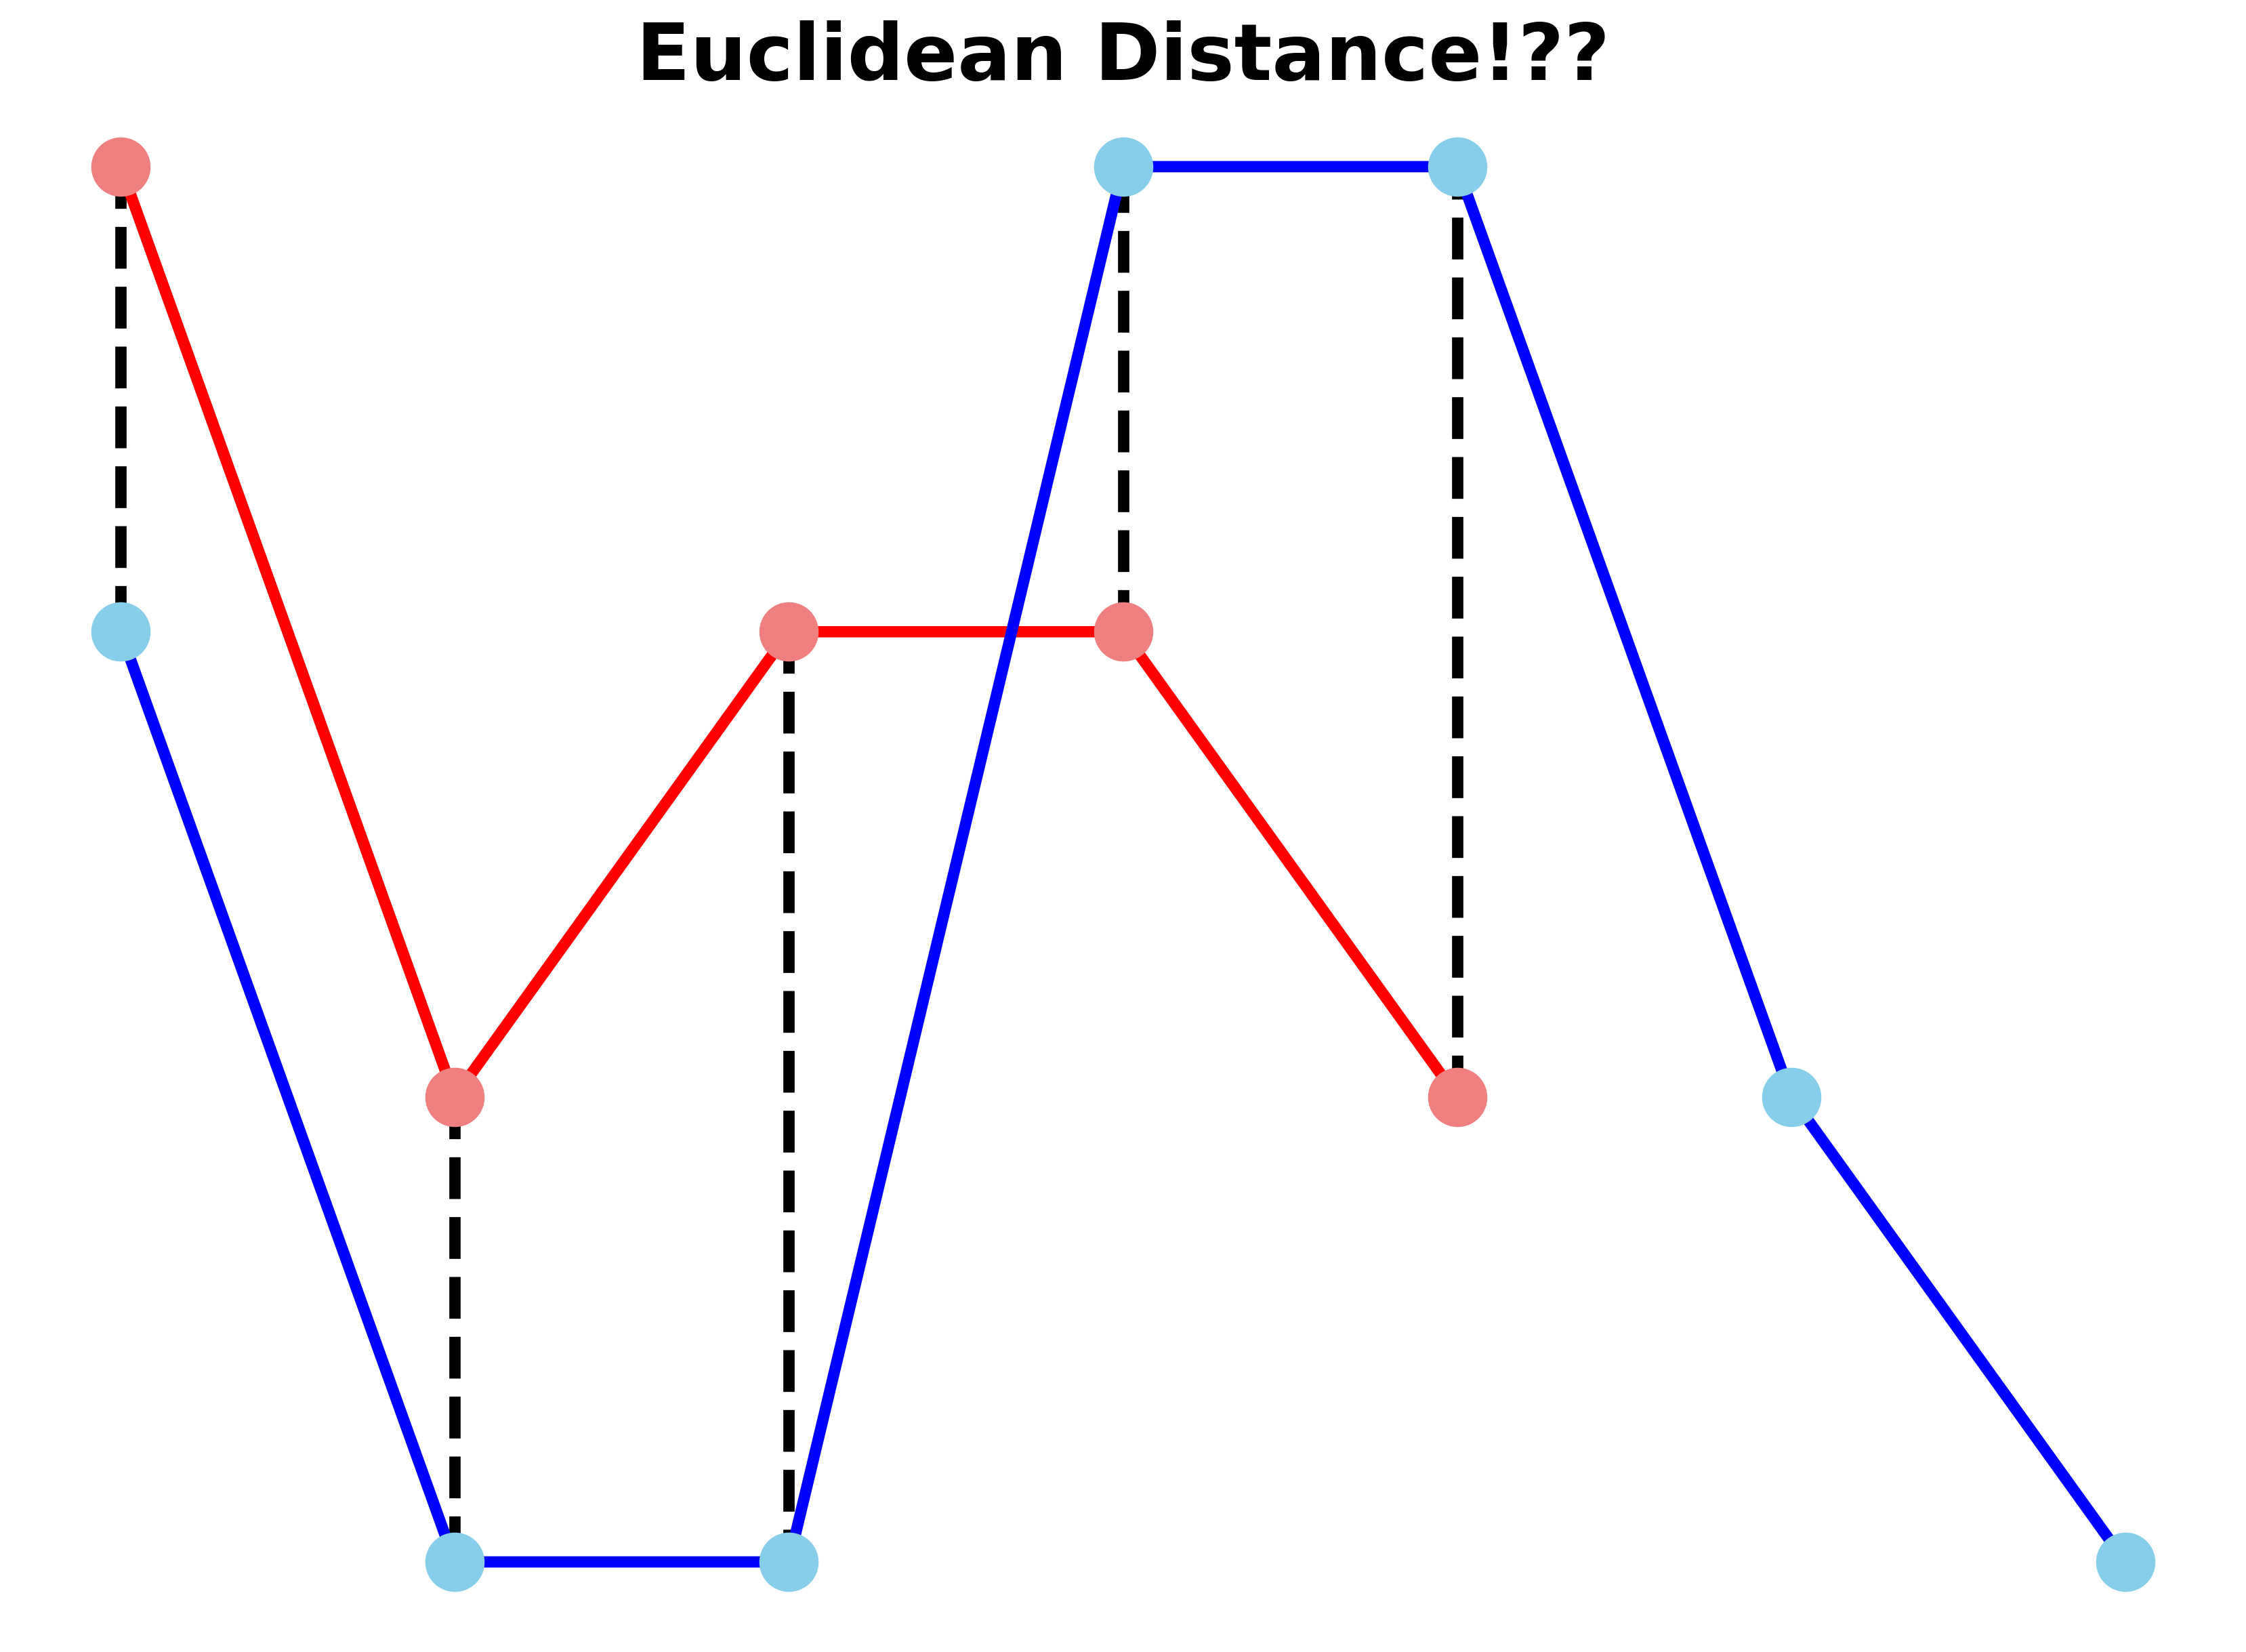

In [5]:
fig, ax = plt.subplots(figsize=(14, 10))

# Remove the border and axes ticks
fig.patch.set_visible(False)
ax.axis('off')

xx = [(i, x[i]) for i in np.arange(0, len(x))]
yy = [(j, y[j]) for j in np.arange(0, len(y))]

for i, j in zip(xx, yy[:-2]):
    ax.plot([i[0], j[0]], [i[1], j[1]], '--k', linewidth=4)

ax.plot(x, '-ro', label='x', linewidth=4, markersize=20, markerfacecolor='lightcoral', markeredgecolor='lightcoral')
ax.plot(y, '-bo', label='y', linewidth=4, markersize=20, markerfacecolor='skyblue', markeredgecolor='skyblue')
ax.set_title("Euclidean Distance!??", fontsize=28, fontweight="bold")

fig.savefig("ex1_euclidean_distance.png", **savefig_options)

### Compute DTW distance and warp path

Many Python packages calculate the DTW by just providing the sequences and the type of distance (usually Euclidean by default). Here, we use a popular Python implementation of DTW that is FastDTW (https://github.com/slaypni/fastdtw) which is an approximate DTW algorithm with lower time and memory complexities $^{[2]}$. 

In [6]:
dtw_distance, warp_path = fastdtw(x, y, dist=euclidean) 


Note that we are using SciPy's distance function Euclidean that we imported earlier. For a better understanding of the warp path, let's first compute the accumulated cost matrix and then visualize the path on a grid. The following code will plot a heatmap of the accumulated cost matrix.

In [7]:
cost_matrix = compute_accumulated_cost_matrix(x, y)

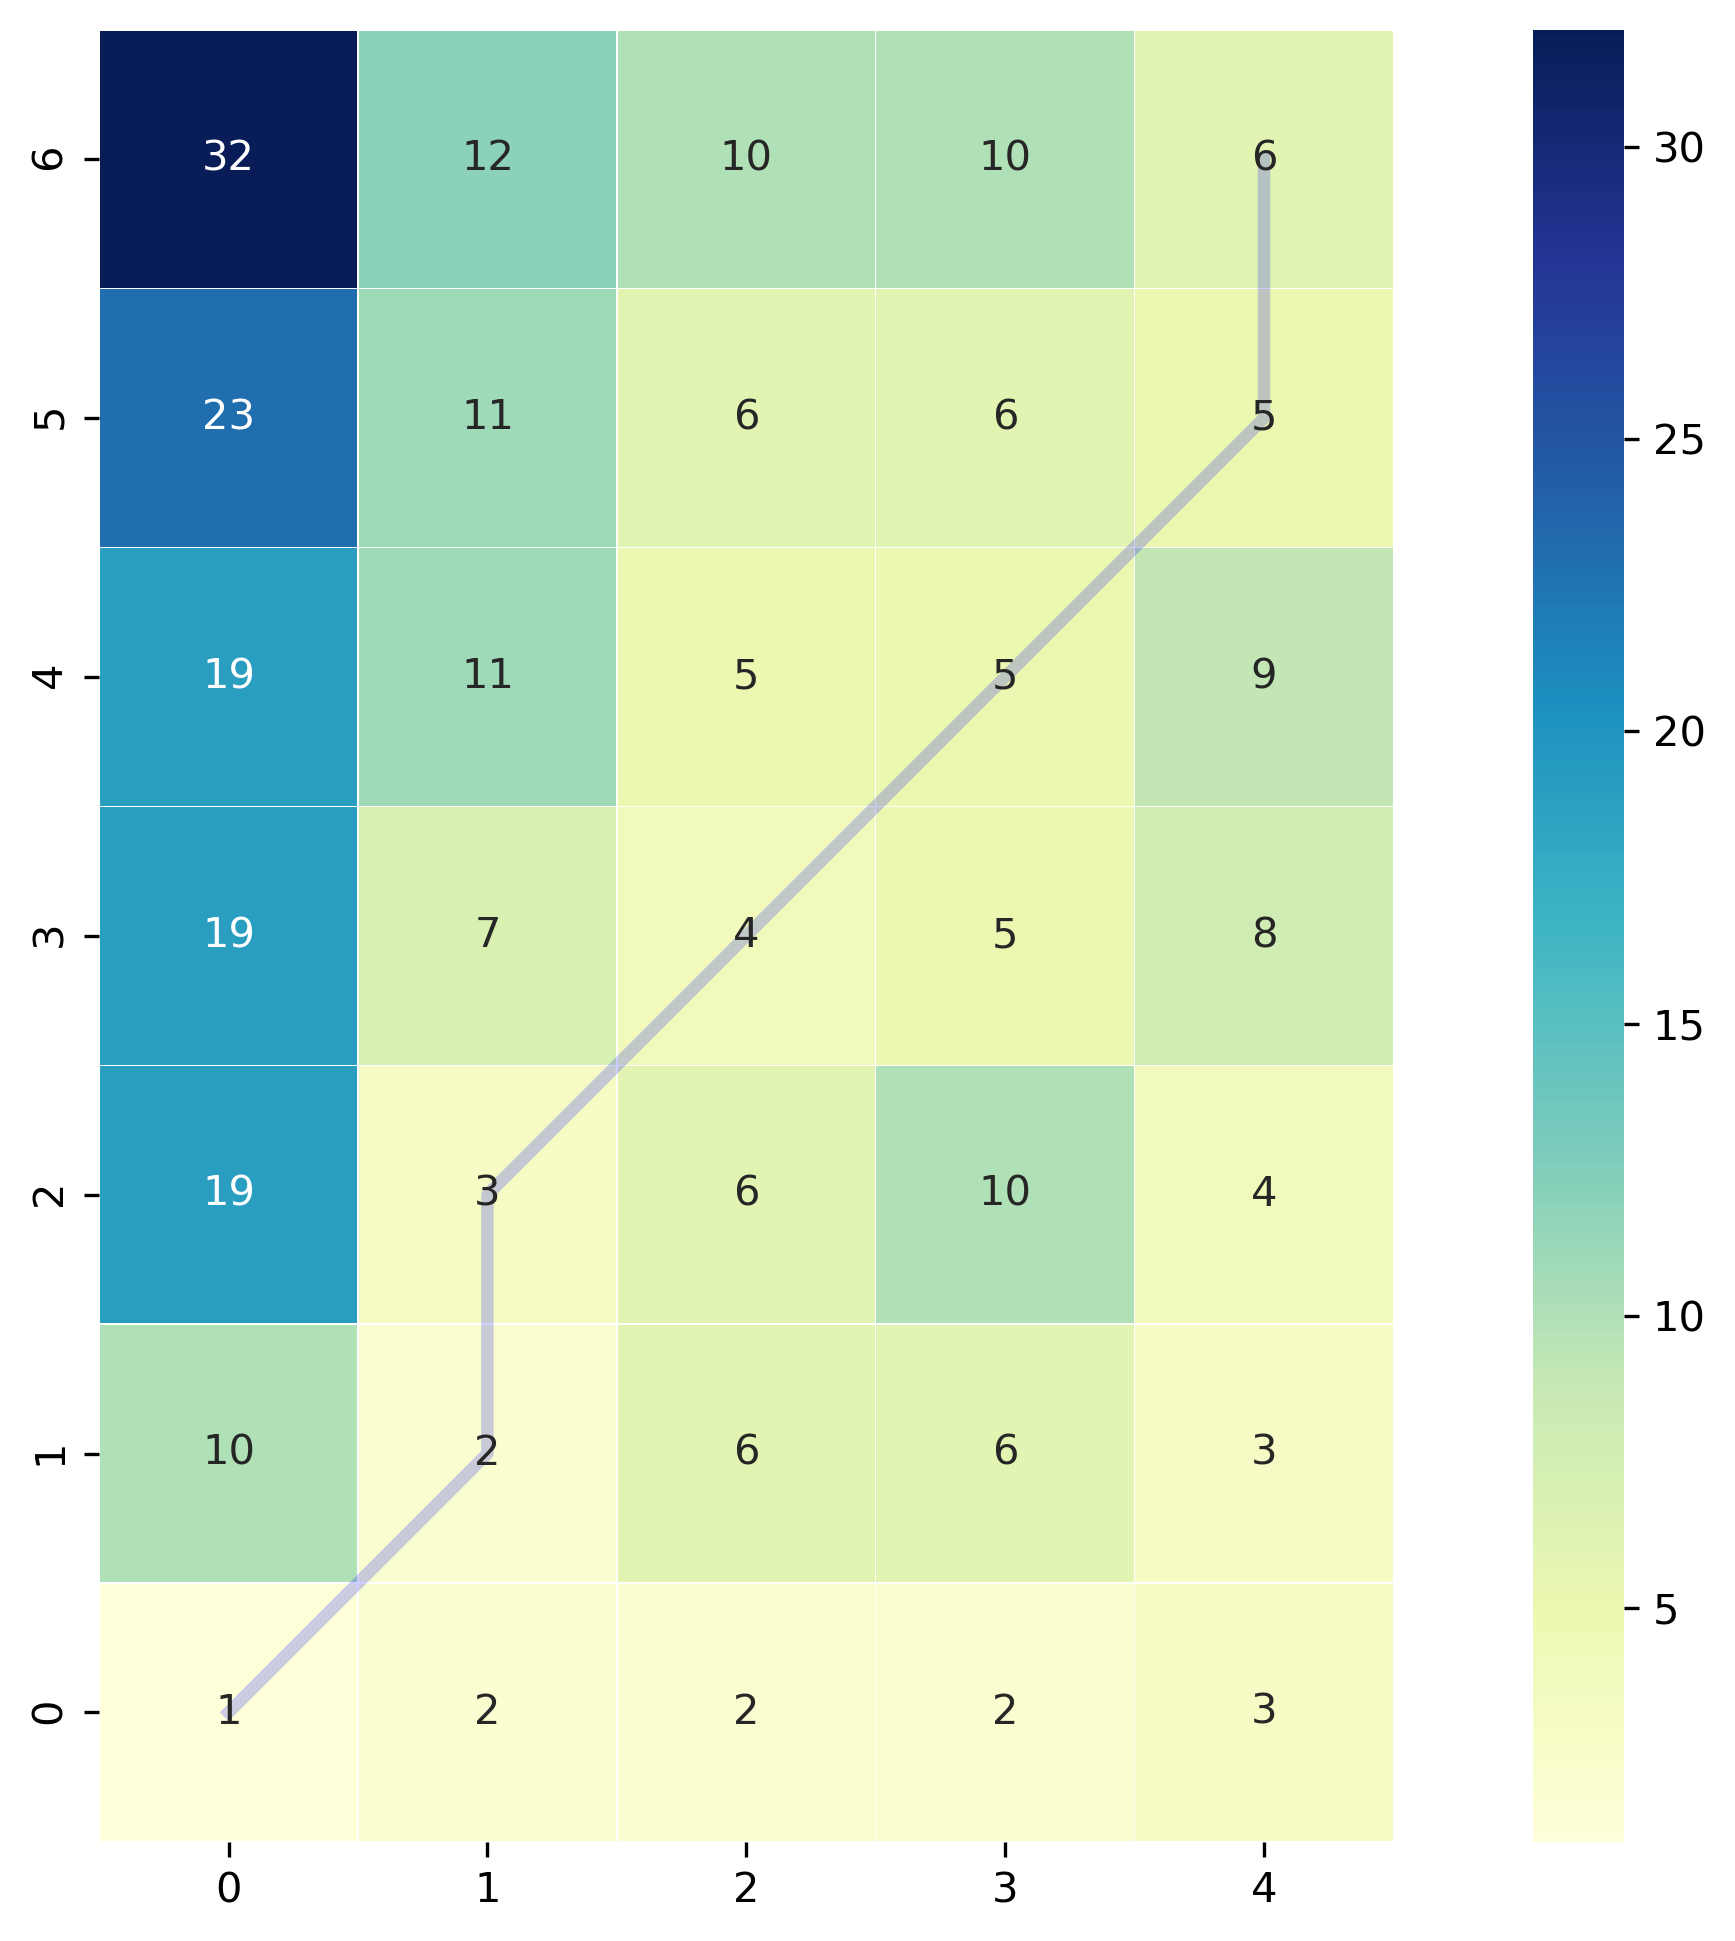

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = sbn.heatmap(cost_matrix, annot=True, square=True, linewidths=0.1, cmap="YlGnBu", ax=ax)
ax.invert_yaxis()

# Get the warp path in x and y directions
path_x = [p[0] for p in warp_path]
path_y = [p[1] for p in warp_path]

# Align the path from the center of each cell
path_xx = [x+0.5 for x in path_x]
path_yy = [y+0.5 for y in path_y]

ax.plot(path_xx, path_yy, color='blue', linewidth=3, alpha=0.2)

fig.savefig("ex1_heatmap.png", **savefig_options)

The color bar shows the cost of each point in the grid. As can be seen, the warp path (blue line) is going through the lowest cost on the grid. Let's see the DTW distance and the warping path by printing these two variables.

In [9]:
print("DTW distance: ", dtw_distance)
print("Warp path: ", warp_path)

DTW distance:  6.0
Warp path:  [(0, 0), (1, 1), (1, 2), (2, 3), (3, 4), (4, 5), (4, 6)]


The warping path starts at point (0, 0) and ends at (4, 6) by 6 moves. Let's also calculate the accumulated cost most using the functions we defined earlier and compare the values with the heatmap.

Now let's plot the two sequences and connect the mapping points. The code to plot the DTW distance between x and y is given below.

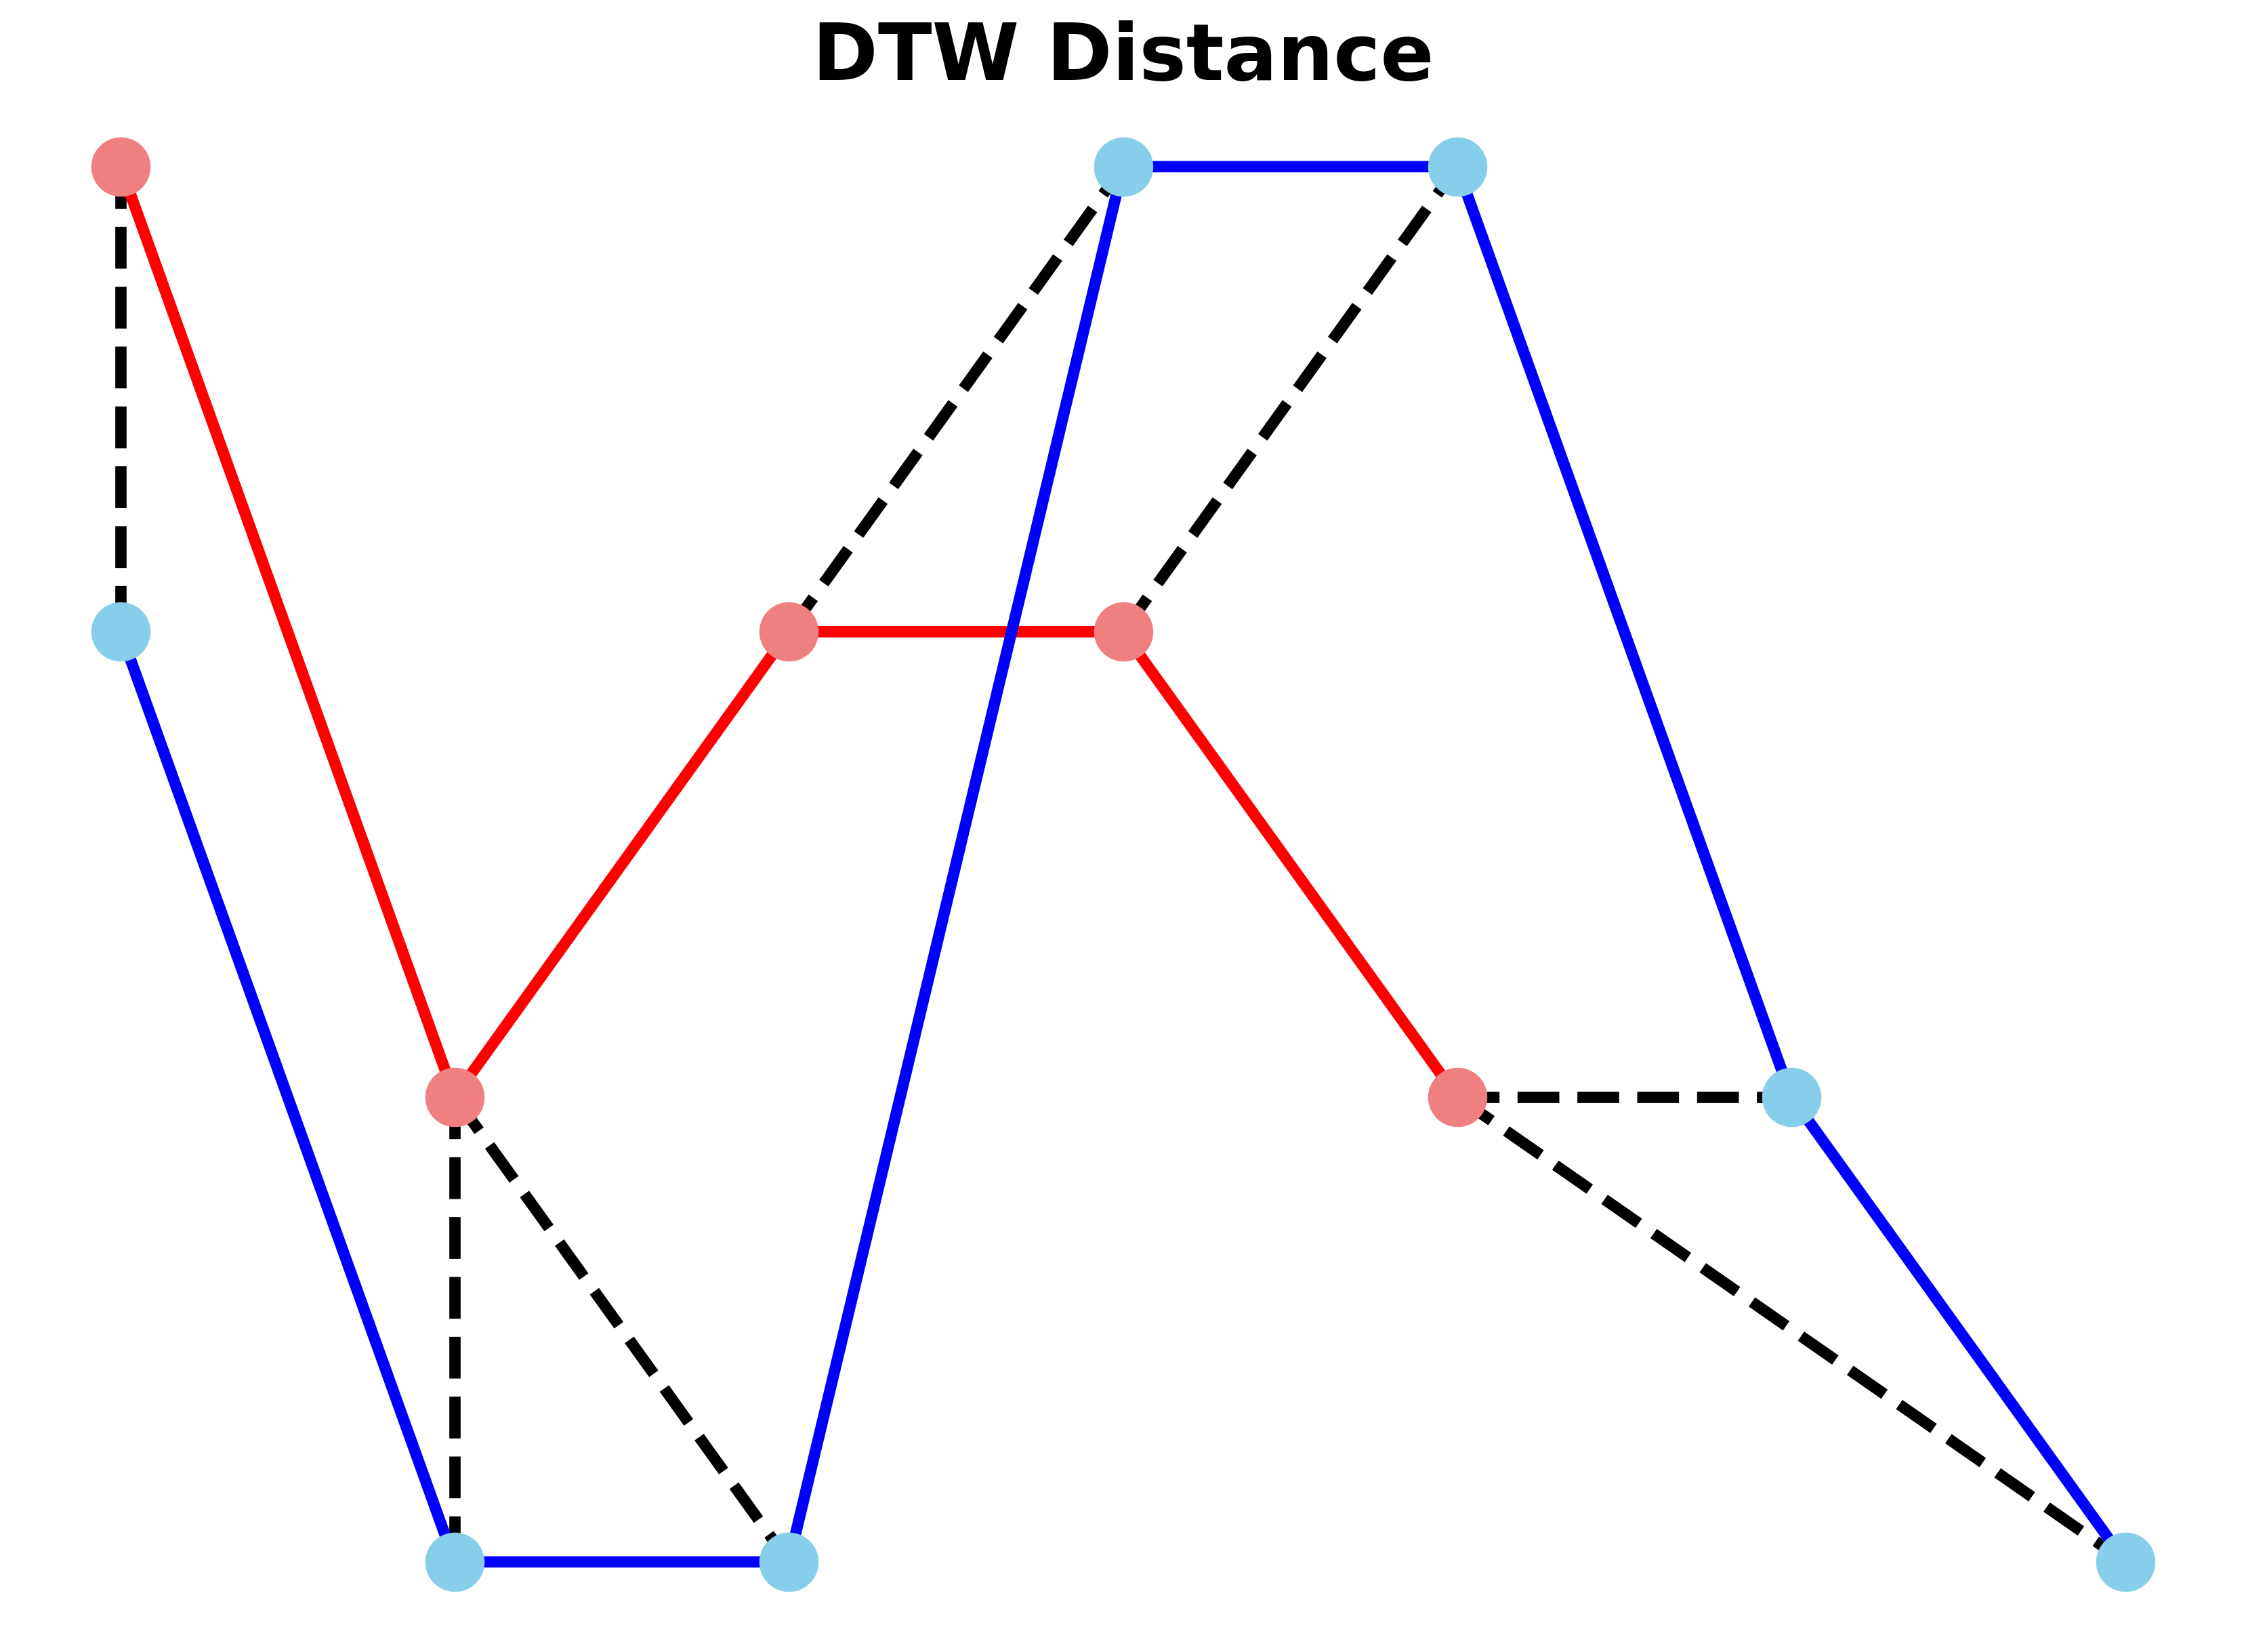

In [10]:
fig, ax = plt.subplots(figsize=(14, 10))

# Remove the border and axes ticks
fig.patch.set_visible(False)
ax.axis('off')

for [map_x, map_y] in warp_path:
    ax.plot([map_x, map_y], [x[map_x], y[map_y]], '--k', linewidth=4)

ax.plot(x, '-ro', label='x', linewidth=4, markersize=20, markerfacecolor='lightcoral', markeredgecolor='lightcoral')
ax.plot(y, '-bo', label='y', linewidth=4, markersize=20, markerfacecolor='skyblue', markeredgecolor='skyblue')
ax.set_title("DTW Distance", fontsize=28, fontweight="bold")

fig.savefig("ex1_dtw_distance.png", **savefig_options)

# Example 2

In this example, we will use two sinusoidal signals and see how they will be matched by calculating the DTW distance between them.

In [11]:
time1 = np.linspace(start=0, stop=1, num=50)
time2 = time1[0:40]

x1 = 3 * np.sin(np.pi * time1) + 1.5 * np.sin(4*np.pi * time1)
x2 = 3 * np.sin(np.pi * time2 + 0.5) + 1.5 * np.sin(4*np.pi * time2 + 0.5) 

Just like Example 1, let's calculate the DTW distance and the warp path for x1 and x2 signals using FastDTW package.

In [12]:
distance, warp_path = fastdtw(x1, x2, dist=euclidean)

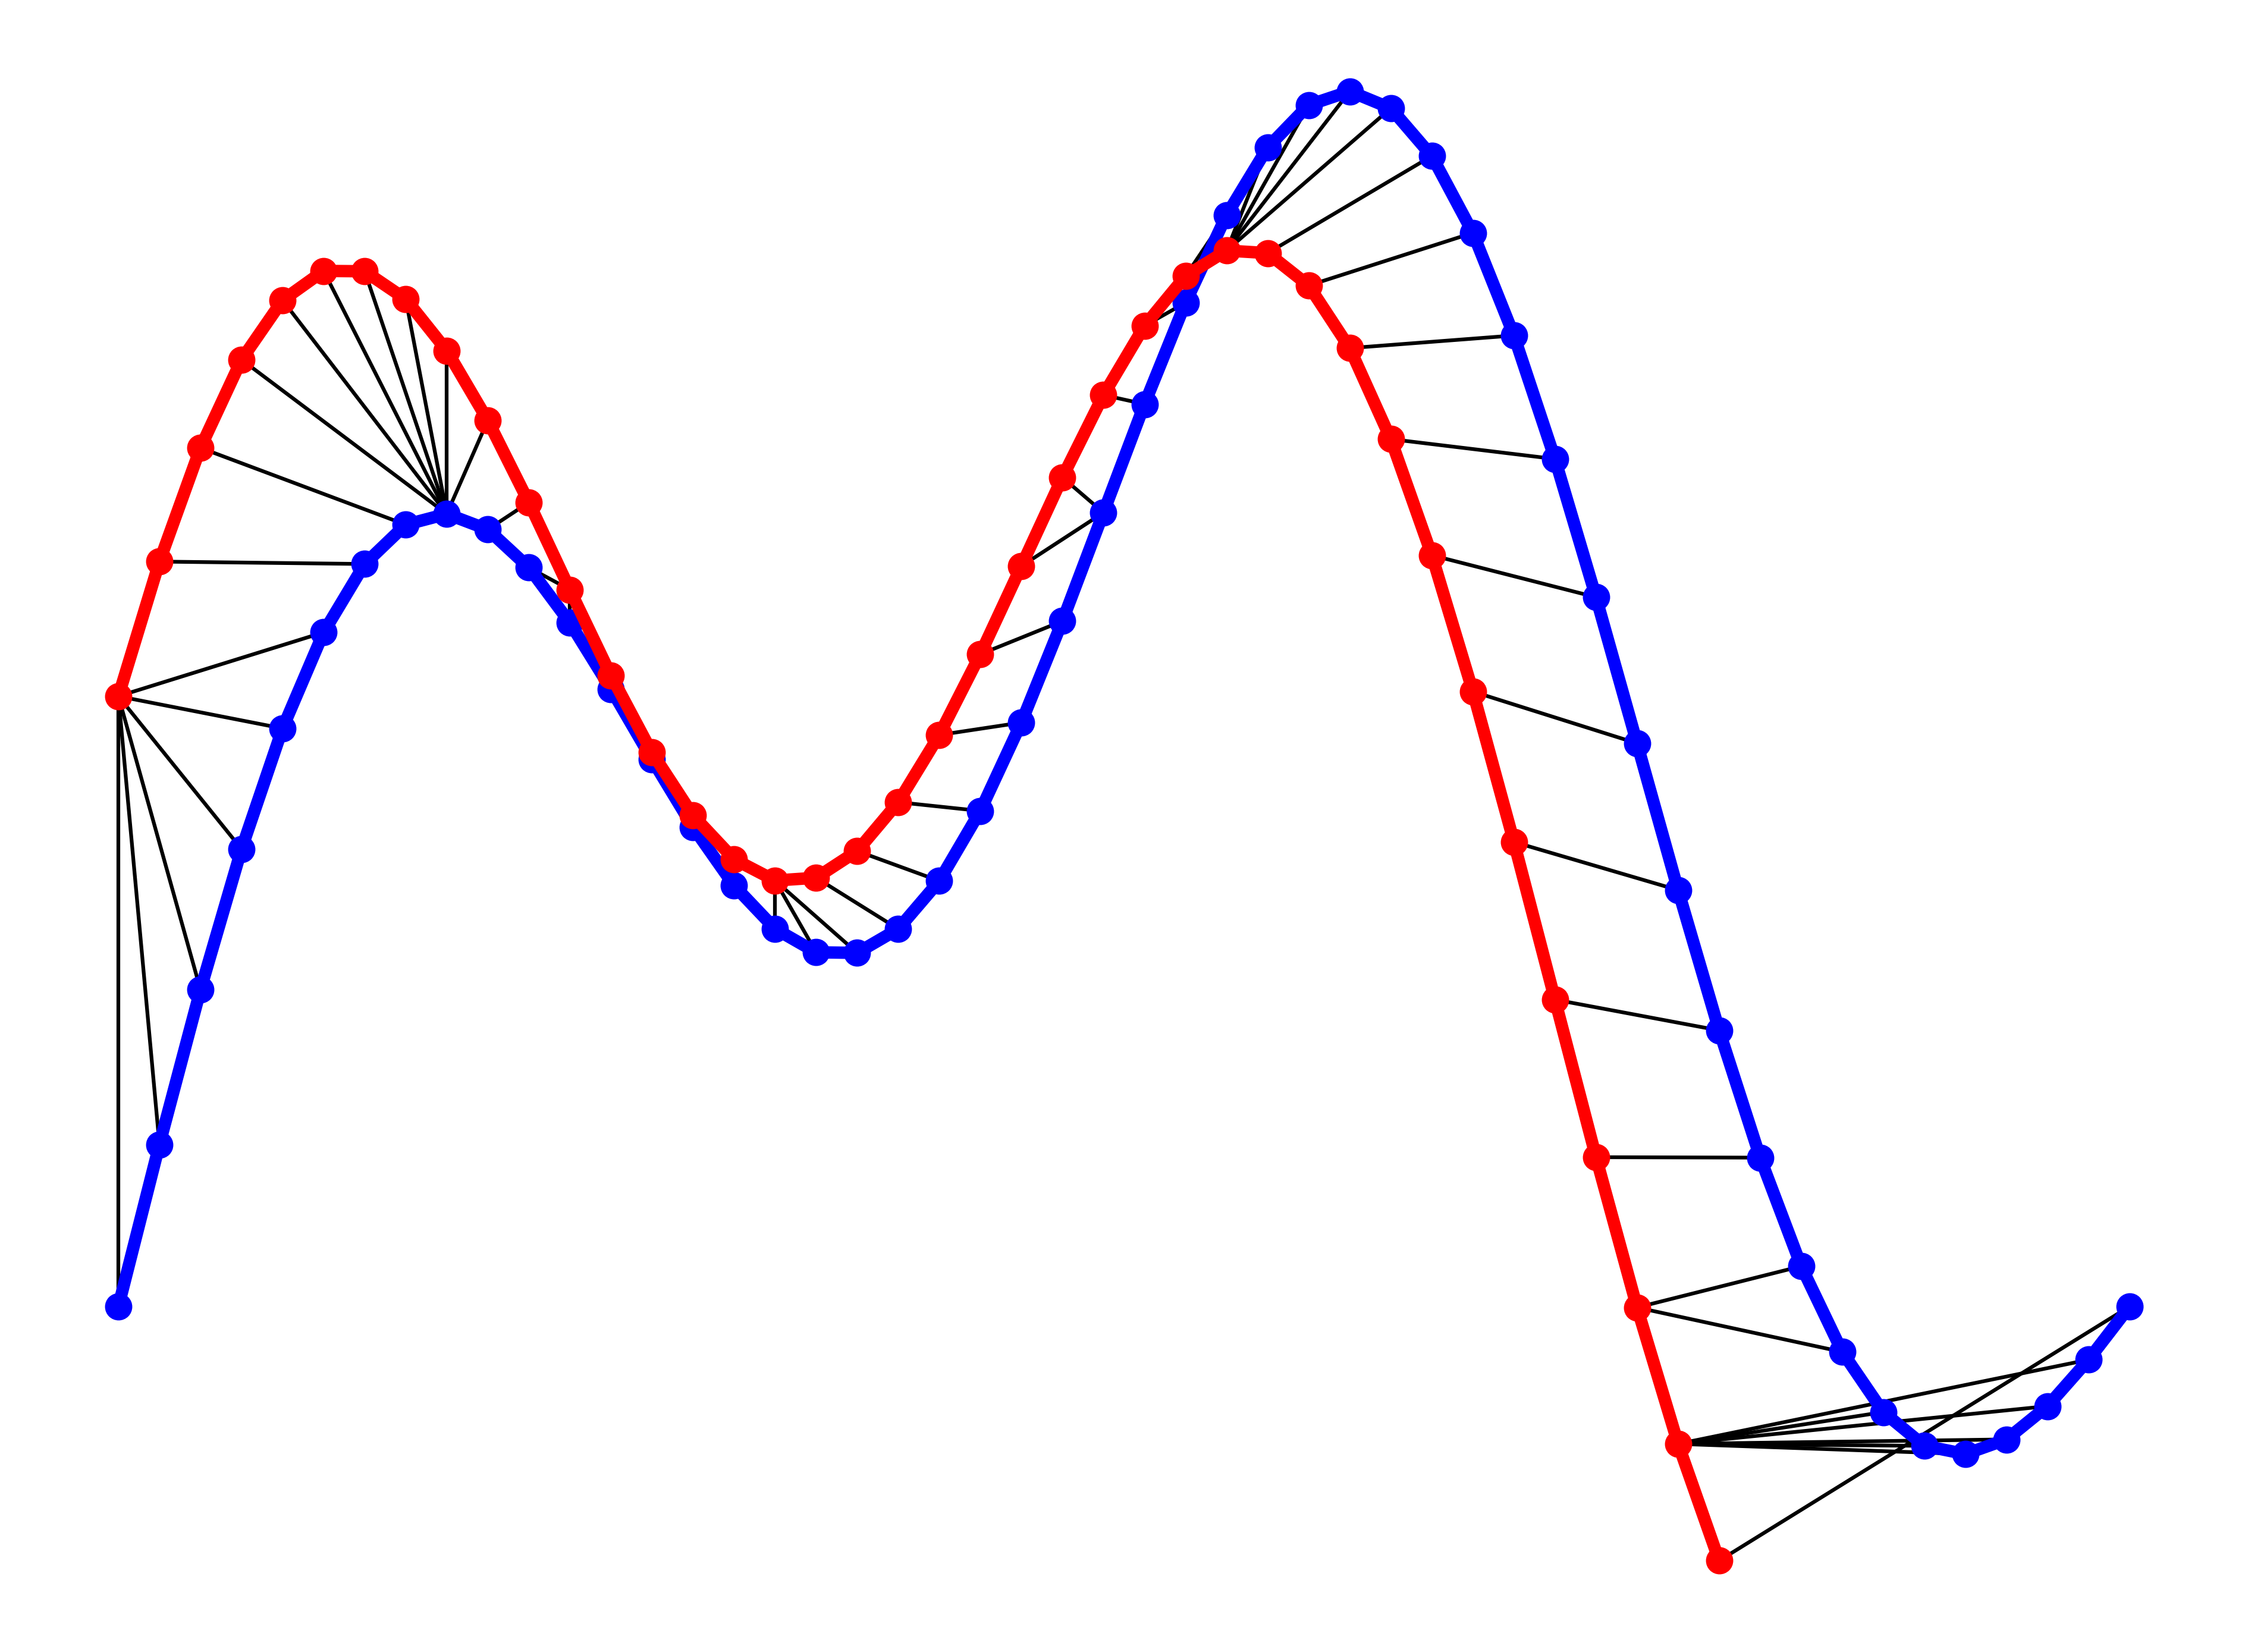

In [13]:
fig, ax = plt.subplots(figsize=(16, 12))

# Remove the border and axes ticks
fig.patch.set_visible(False)
ax.axis('off')

for [map_x, map_y] in warp_path:
    ax.plot([map_x, map_y], [x1[map_x], x2[map_y]], '-k')

ax.plot(x1, color='blue', marker='o', markersize=10, linewidth=5)
ax.plot(x2, color='red', marker='o', markersize=10, linewidth=5)
ax.tick_params(axis="both", which="major", labelsize=18)

fig.savefig("ex2_dtw_distance.png", **savefig_options)

As can be seen in above figure, the DTW distance between the two signals is particularly powerful when the signals have similar patterns. The extrema (maximum and minimum points) between the two signals are correctly mapped. Moreover, unlike Euclidean distance, we may see many-to-one mapping when DTW distance is used, particularly if the two signals have different lengths. 

You may spot an issue with dynamic time warping from the figure above. Can you guess what it is?

The issue is around the head and tail of time-series that do not properly match. This is because the DTW algorithm cannot afford the warping invariance for at the endpoints. In short, the effect of this is that a small difference at the sequence endpoints will tend to contribute disproportionately to the estimated similarity$^{[3]}$.

# Conclusion
DTW is an algorithm to find an optimal alignment between two sequences and a useful distance metric to have in our toolbox. This technique is useful when we are working with two non-linear sequences, particularly if one sequence is a non-linear stretched/shrunk version of the other. The warping path is a combination of "chess king" moves that starts from the head of two sequences and ends with their tails.

Thanks for reading!

# References
[1] Donald J. Berndt and James Clifford, _Using Dynamic Time Warping to Find Patterns in Time Series_ 
        (https://www.aaai.org/Papers/Workshops/1994/WS-94-03/WS94-03-031.pdf)
        
        
[2] Stan Salvador and Philip Chan, _"FastDTW: Toward Accurate Dynamic Time Warping in Linear Time and Space"_ 
        (https://cs.fit.edu/~pkc/papers/tdm04.pdf)
        
        
[3] Diego Furtado Silva, _et al._, _On the effect of endpoints on dynamic time warping_
        (https://core.ac.uk/display/147806669)

# Useful Links

* https://nipunbatra.github.io/blog/ml/2014/05/01/dtw.html


* https://databricks.com/blog/2019/04/30/understanding-dynamic-time-warping.html
